# Postprocessing for the eigenvalue solutions

In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, h5py
from pg_utils.processing import postproc as pproc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compare eigenvalues

Read in eigenvalue solutions

In [2]:
solution_file_list = [
    "./out/solutions/Malkus/Eigen_recipe-Daria_mm.hdf5", 
    "./out/solutions/Malkus/Eigen_recipe-Daria.h5", 
    "./out/solutions/Malkus/Eigen_recipe-Daria_scipy.h5", 
    "./out/cases/Malkus/Eigen.h5"
]
src_names = [
    "Code Daria Mathematica", 
    "PlesioGeostroPy-mp32", 
    "PlesioGeostroPy-scipy", 
    "PlesioGeostroPy-module"
]

solution_list = list()
for idx, fname in enumerate(solution_file_list):
    with h5py.File(fname, 'r') as f:
        solution_list.append(f["eigval"][()])

For Mathematica outputs, must convert to imaginary

In [3]:
solution_list[0] = 1j*solution_list[0]

Sort east/west modes

In [4]:
df_east = pd.DataFrame()
df_west = pd.DataFrame()

for idx, srcname in enumerate(src_names):
    eig_val_tmp = solution_list[idx]
    eigidx_east = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) < -1e-3]
    eigidx_west = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) > +1e-3]
    df_east[srcname] = eig_val_tmp[eigidx_east]
    df_west[srcname] = eig_val_tmp[eigidx_west]

Load analytical

In [5]:
from pg_utils.numerics import utils as nutils

n_eigs = np.arange(1, 7)
omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(3, n_eigs, 1e-4, mode="all", timescale="alfven")

df_east["Analytic PG"] = omega_fast*1j
df_west["Analytic PG"] = np.flip(omega_slow)*1j

omega_fast, omega_slow = nutils.eigenfreq_Malkus_3d(3, n_eigs, 1e-4, mode="all", timescale="alfven")

df_east["Analytic 3D"] = omega_fast*1j
df_west["Analytic 3D"] = np.flip(omega_slow)*1j

Output

In [8]:
df_east.transpose().style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.7e}j".format(x))

,0,1,2,3,4,5
Code Daria Mathematica,"1.20e-34,-2.3529453e+03j","4.19e-35,-1.1650566e+03j","-3.05e-35,-7.0176751e+02j","-5.12e-35,-4.7060765e+02j","-2.12e-35,-3.3805503e+02j","-2.41e-34,-2.5481247e+02j"
PlesioGeostroPy-mp32,"0.00e+00,-2.3529453e+03j","2.01e-21,-1.1650566e+03j","1.14e-13,-7.0176750e+02j","6.35e-15,-4.7060763e+02j","8.54e-14,-3.3805499e+02j","9.81e-17,-2.5481240e+02j"
PlesioGeostroPy-scipy,"0.00e+00,-2.3529453e+03j","-3.31e-21,-1.1650566e+03j","2.27e-13,-7.0176750e+02j","9.26e-14,-4.7060763e+02j","7.45e-14,-3.3805499e+02j","-6.47e-16,-2.5481240e+02j"
PlesioGeostroPy-module,"0.00e+00,-2.3529453e+03j","-3.31e-21,-1.1650566e+03j","2.27e-13,-7.0176750e+02j","9.26e-14,-4.7060763e+02j","7.45e-14,-3.3805499e+02j","-6.47e-16,-2.5481240e+02j"
Analytic PG,"-0.00e+00,-2.3529453e+03j","-0.00e+00,-1.1650566e+03j","-0.00e+00,-7.0176751e+02j","-0.00e+00,-4.7060766e+02j","-0.00e+00,-3.3805509e+02j","-0.00e+00,-2.5481269e+02j"
Analytic 3D,"-0.00e+00,-2.5319765e+03j","-0.00e+00,-1.1874052e+03j","-0.00e+00,-7.0680028e+02j","-0.00e+00,-4.7215532e+02j","-0.00e+00,-3.3863603e+02j","-0.00e+00,-2.5506357e+02j"


In [10]:
df_west.transpose().style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.6e}j".format(x))

,0,1,2,3,4,5
Code Daria Mathematica,"-1.76e-32,3.537884e-02j","8.72e-32,2.684780e-02j","-2.58e-31,1.940629e-02j","4.96e-31,1.312252e-02j","-3.07e-31,8.025441e-03j","6.50e-33,4.125273e-03j"
PlesioGeostroPy-mp32,"-1.06e-14,3.533362e-02j","-2.38e-14,2.682231e-02j","-8.17e-15,1.939363e-02j","-1.38e-15,1.311719e-02j","-1.03e-14,8.023644e-03j","6.91e-15,4.124898e-03j"
PlesioGeostroPy-scipy,"6.22e-14,3.533362e-02j","6.25e-14,2.682231e-02j","3.82e-14,1.939363e-02j","1.58e-14,1.311719e-02j","1.24e-14,8.023644e-03j","-1.26e-15,4.124898e-03j"
PlesioGeostroPy-module,"6.22e-14,3.533362e-02j","6.25e-14,2.682231e-02j","3.82e-14,1.939363e-02j","1.58e-14,1.311719e-02j","1.24e-14,8.023644e-03j","-1.26e-15,4.124898e-03j"
Analytic PG,"0.00e+00,3.562002e-02j","0.00e+00,2.692286e-02j","0.00e+00,1.942420e-02j","0.00e+00,1.312475e-02j","0.00e+00,8.024945e-03j","0.00e+00,4.124993e-03j"
Analytic 3D,"0.00e+00,3.558528e-02j","0.00e+00,2.687718e-02j","0.00e+00,1.936151e-02j","0.00e+00,1.303344e-02j","0.00e+00,7.879550e-03j","0.00e+00,3.854535e-03j"


Plotting

,0,1,2,3,4,5
Code Daria Mathematica,1.025e-07,6.442e-08,2.551e-08,4.755e-09,1.469e-09,1.102e-09
PlesioGeostroPy-mp32,1.217e-07,8.630e-08,4.356e-08,1.607e-08,3.848e-09,3.701e-10
PlesioGeostroPy-scipy,1.217e-07,8.630e-08,4.356e-08,1.607e-08,3.848e-09,3.701e-10


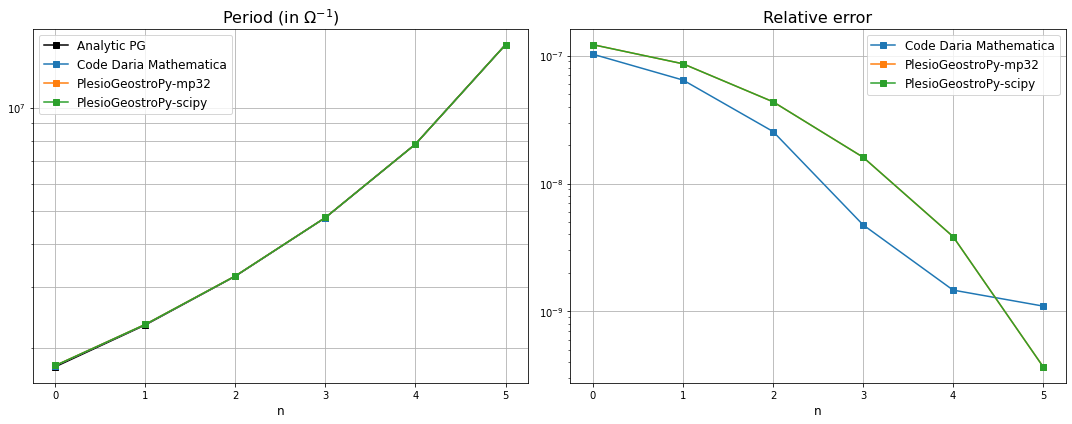

In [66]:
df_compare = df_west
compare_ref = "Analytic PG"
save_name = "./out/imgs/err_comparison_west__PG"
override = True

df_compare_err = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    df_compare_err[srcname] = np.abs(df_compare[compare_ref] - df_compare[srcname])/np.abs(df_east[compare_ref])
display(df_compare_err.transpose().style.format(formatter=lambda x: "{:.3e}".format(x)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.semilogy(np.arange(6), 2*np.pi*1e+4/np.abs(np.imag(df_compare[compare_ref])), 'ks-', label=compare_ref)
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(6), 2*np.pi*1e+4/np.abs(np.imag(df_compare[srcname])), 's-', label=srcname)
ax.grid(which="both")
ax.legend(fontsize=12)
ax.set_xlabel("n", fontsize=12)
ax.set_title("Period (in $\Omega^{-1}$)", fontsize=16)

ax = axes[1]
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(6), df_compare_err[srcname], 's-', label=srcname)
ax.grid(which="major")
ax.legend(fontsize=12)
ax.set_xlabel("n", fontsize=12)
ax.set_title("Relative error", fontsize=16)

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.pdf') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.pdf', format="pdf", dpi=150, bbox_inches="tight")
plt.show()

## Visualization

Select a file to start

In [77]:
from sympy import diff

vorticity = (diff(core.s*core.U_pg[1], core.s) - diff(core.U_pg[0], core.p))/core.s
vorticity.expand()

-Derivative(\Psi(s, \phi, t), (s, 2))/H(s) + Derivative(H(s), s)*Derivative(\Psi(s, \phi, t), s)/H(s)**2 - Derivative(\Psi(s, \phi, t), s)/(s*H(s)) - Derivative(\Psi(s, \phi, t), (\phi, 2))/(s**2*H(s))

In [80]:
vorticity = (diff(core.H, core.s)*diff(core.pgvar.Psi, core.s)/core.H - diff(core.s*diff(core.pgvar.Psi, core.s), core.s)/core.s - diff(core.pgvar.Psi, (core.p, 2))/core.s**2)/core.H
vorticity.expand()

-Derivative(\Psi(s, \phi, t), (s, 2))/H(s) + Derivative(H(s), s)*Derivative(\Psi(s, \phi, t), s)/H(s)**2 - Derivative(\Psi(s, \phi, t), s)/(s*H(s)) - Derivative(\Psi(s, \phi, t), (\phi, 2))/(s**2*H(s))

In [86]:
eigenfile = "./out/cases/Malkus/Eigen.h5"

with h5py.File(eigenfile, 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    azm_val = fread.attrs["azm"]
    Le_val = fread.attrs["Le"]
    Lu_val = fread.attrs["Lu"]
    cnames = list(fread["bases"]["names"].asstr()[()])
    ranges_trial = fread["bases"]["ranges"][()]
    eig_vals = fread["eigval"][()]
    eig_vecs = fread["eigvec"][()]

# Sort east-west modes
eigidx_east = np.arange(eig_val.size)[np.imag(eig_val) < -1e-7]
eigidx_west = np.arange(eig_val.size)[np.imag(eig_val) > +1e-7]
eigval_east = eig_val[eigidx_east]
eigval_west = eig_val[eigidx_west]
eigvec_east = eig_vec[:, eigidx_east]
eigvec_west = eig_vec[:, eigidx_west]

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

# Expansion range
field_nrange = {fname: ranges_trial[i_field] for i_field, fname in enumerate(fnames)}
field_nrange["U_s"] = field_nrange["Psi"]
field_nrange["U_p"] = field_nrange["Psi"]
field_nrange["U_z"] = field_nrange["Psi"]
field_nrange["Zeta"] = field_nrange["Psi"]

In [98]:
print(field_func.Zeta.__doc__)

Created with lambdify. Signature:

func(s, \phi, z, \ell, C_{\Psi}^{mn}, C_{ss}^{mn}, C_{\phi\phi}^{mn},
        C_{s\phi}^{mn}, C_{sz}^{mn}, C_{\phi z}^{mn}, C_{zss}^{mn},
        C_{z\phi\phi}^{mn}, C_{zs\phi}^{mn}, C_{es}^{mn},
        C_{e\phi}^{mn}, C_{ez}^{mn}, C_{es,z}^{mn}, C_{e\phi,z}^{mn})

Expression:

C_{\Psi}^{mn}*s**3*(4*\ell**2*s**4*jacobi(\ell - 2, 7/2, 5, 2*s**2 - 1) -...

Source code:

def _lambdifygenerated(s, Dummy_2863, z, Dummy_2864, Dummy_2878, Dummy_2869, Dummy_2876, Dummy_2870, Dummy_2868, Dummy_2877, Dummy_2865, Dummy_2867, Dummy_2866, Dummy_2872, Dummy_2874, Dummy_2871, Dummy_2873, Dummy_2875):
    return Dummy_2878*s**3*(4*Dummy_2864**2*s**4*eval_jacobi(Dummy_2864 - 2, 7/2, 5, 2*s**2 - 1) - 4*Dummy_2864**2*s**2*eval_jacobi(Dummy_2864 - 2, 7/2, 5, 2*s**2 - 1) + 48*Dummy_2864*s**4*eval_jacobi(Dummy_2864 - 2, 7/2, 5, 2*s**2 - 1) - 48*Dummy_2864*s**2*eval_jacobi(Dummy_2864 - 2, 7/2, 5, 2*s**2 - 1) + 26*Dummy_2864*s**2*eval_jacobi(Dummy_2864 - 1, 5/2, 4, 2*s**2 -

Configure the expansion

In [83]:
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import cfg_expand as xpd_cfg
from pg_utils.numerics import matrices as nmatrix

field_func = pproc.get_eigen_field_function(xpd_cfg.recipe, physical_params)

Select an eigenvalue to visualize

In [53]:
mode, idx = "fast", 5
if mode == "fast":
    eigval, eigvec = eigval_east[idx], eigvec_east[:, idx]
elif mode == "slow":
    eigval, eigvec = eigval_west[idx], eigvec_west[:, idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, cnames, ranges_trial)
eigvec = base.LabeledCollection(cnames, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(xpd_cfg.recipe.rad_xpd.coeffs, eigvec)

### Radial plot

For radial plot, $\phi=Cst$, $z=Cst$.

In [54]:
p_cst = np.pi/4
z_cst = 0
s_array = np.linspace(0, 1, num=100)

Alternatively, one can use a list of s points corresponding to spacing in $\xi$

In [55]:
from scipy import special as specfun

xi_array, _ = specfun.roots_chebyt(100)
s_array = np.sqrt((1 + xi_array)/2)

Calculate all fields

In [56]:
def calc_field_rad(fname, field_f):
    S_mesh, N_mesh = np.meshgrid(s_array, field_nrange[fname], indexing='ij')
    eval_tmp = field_f(S_mesh, p_cst, z_cst, N_mesh, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

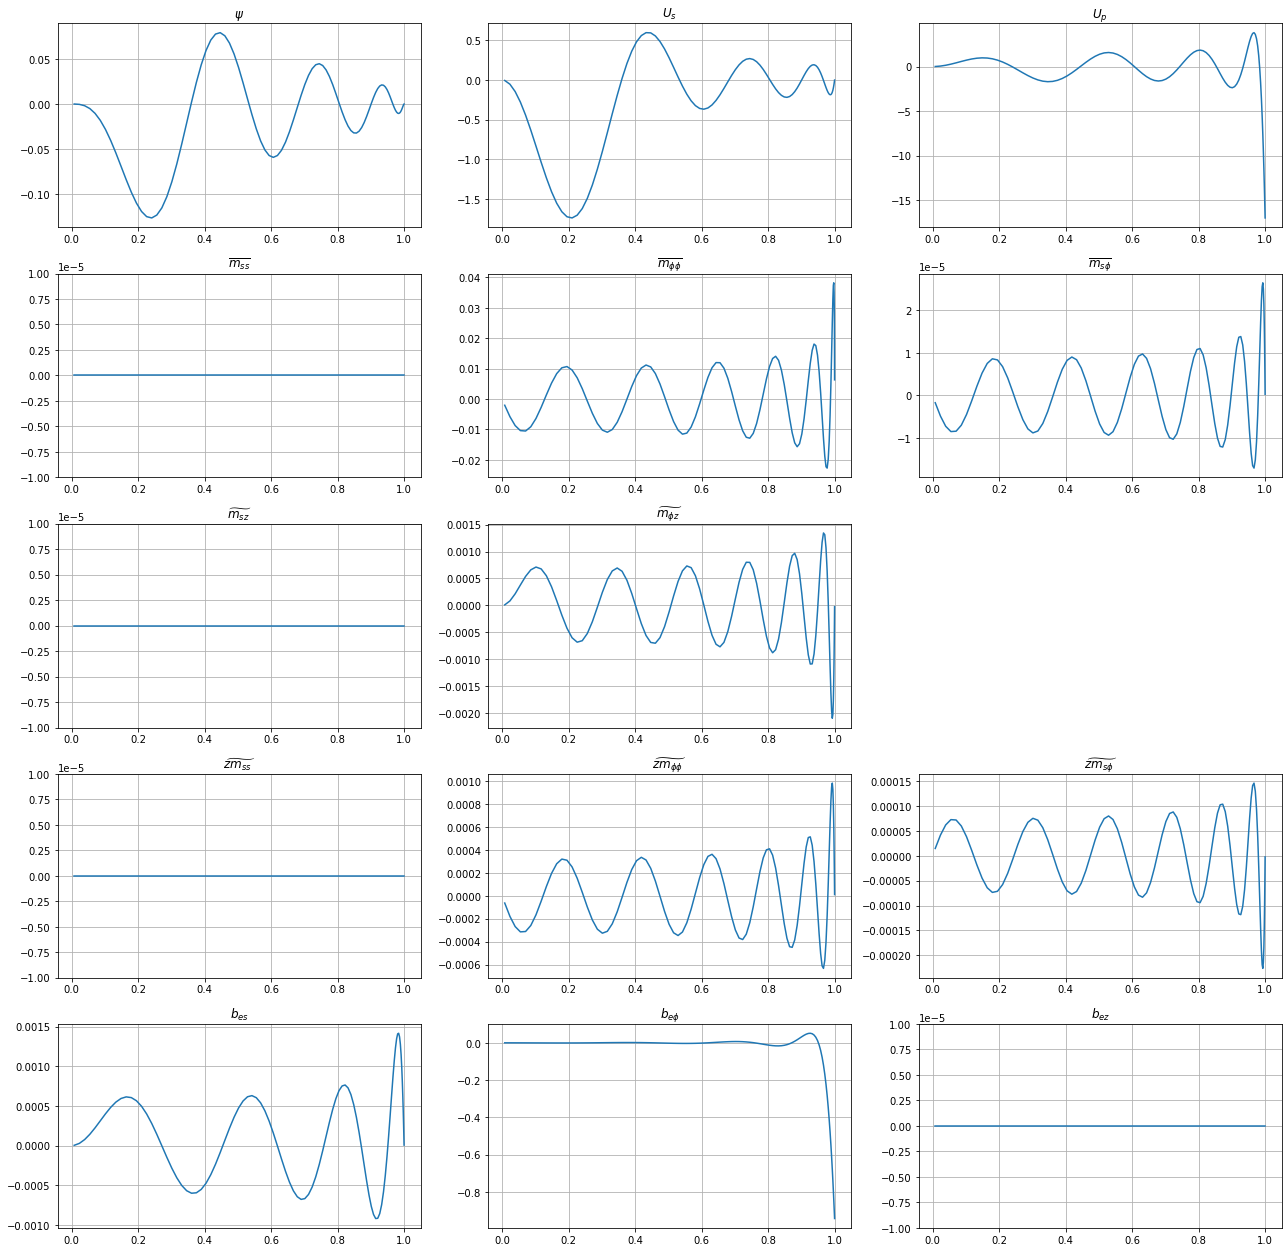

In [60]:
plot_fields = [["Psi", "U_s", "U_p"],
               ["Mss", "Mpp", "Msp"], 
               ["Msz", "Mpz", None], 
               ["zMss", "zMpp", "zMsp"], 
               ["Bs_e", "Bp_e", "Bz_e"]]

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*3.5))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        ax.plot(s_array, np.real(eigmode_eval[fname]))
        if np.abs(np.real(eigmode_eval[fname])).max() < 1e-5:
            ax.set_ylim([-1e-5, +1e-5])
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar_ptb[fname].name,))
        else:
            ax.set_title(r'$%s$' % (fname,))
        ax.grid(True)

plt.tight_layout()
plt.show()

### Equatorial plane plot

For Equatorial plane section, $z=0$. $s$ and $p$ form a mesh of grid points.

In [95]:
z_cst = 0
s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, np.pi/2, num=100)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

Calculate all fields

In [96]:
def calc_field_rad(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([P_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, z_cst, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

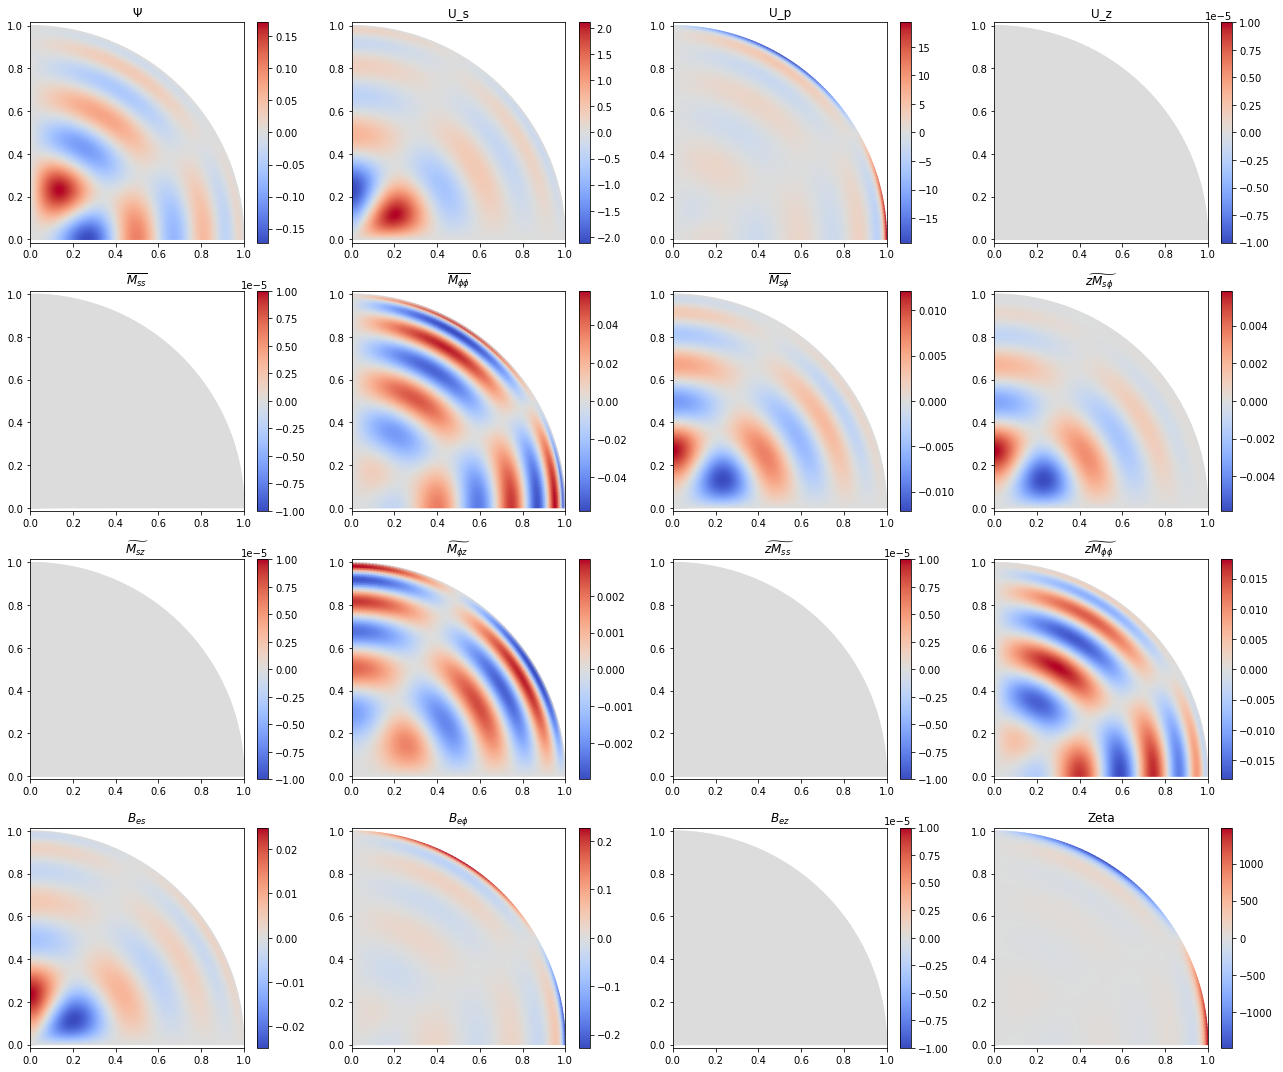

In [99]:
plot_fields = [["Psi", "U_s", "U_p", "U_z"],
               ["Mss", "Mpp", "Msp", "zMsp"], 
               ["Msz", "Mpz", "zMss", "zMpp"], 
               ["Bs_e", "Bp_e", "Bz_e", "Zeta"]]
save_name = None
# save_name = "./out/solutions/Malkus/m3n5_sympy_eqplot"
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.75))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,))
        else:
            ax.set_title(fname)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Meridional plane plot

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [91]:
p_cst = np.pi/4
r_array = np.linspace(0, 1, num=100)
theta_array = np.linspace(0, np.pi/2, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(P_mesh), R_mesh*np.cos(P_mesh)

Calculate all fields

In [92]:
def calc_field_rad(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, p_cst, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

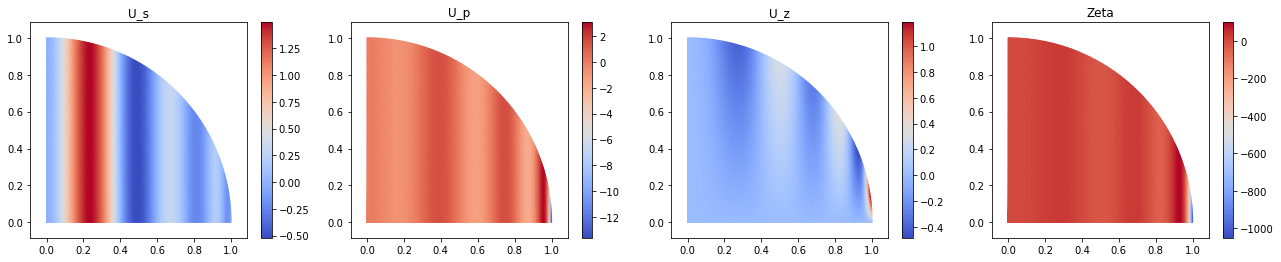

In [93]:
plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
# save_name = "./out/solutions/Malkus/m3n5_sympy_mdplot"
save_name = None
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.75))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.real(eigmode_eval[fname]).max() > 1e-5:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,))
        else:
            ax.set_title(fname)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Output to 3-D visualization

In [115]:
r_array = np.arange(0.05, 1, 0.1)
theta_array = np.arange(0, 181, 5)
phi_array = np.arange(0, 360, 5)

R_mesh, Phi_mesh, Theta_mesh = np.meshgrid(r_array, np.radians(phi_array), np.radians(theta_array), indexing='ij')
S_mesh = R_mesh*np.sin(Theta_mesh)
Z_mesh = R_mesh*np.cos(Theta_mesh)

def calc_field_3d(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Phi_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

Zeta_mesh = calc_field_3d("Zeta", field_func.Zeta)
Uz_mesh = calc_field_3d("U_z", field_func.U_z)

In [117]:
np.savez("./out/cases/Malkus/3darray.npz", r_array=r_array, theta_array=theta_array, phi_array=phi_array, Zeta=Zeta_mesh, Uz=Uz_mesh)

In [115]:
r_array = np.arange(0.05, 1, 0.1)
theta_array = np.arange(0, 181, 5)
phi_array = np.arange(0, 360, 5)

R_mesh, Phi_mesh, Theta_mesh = np.meshgrid(r_array, np.radians(phi_array), np.radians(theta_array), indexing='ij')
S_mesh = R_mesh*np.sin(Theta_mesh)
Z_mesh = R_mesh*np.cos(Theta_mesh)

def calc_field_3d(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Phi_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

Zeta_mesh = calc_field_3d("Zeta", field_func.Zeta)
Uz_mesh = calc_field_3d("U_z", field_func.U_z)

In [117]:
np.savez("./out/cases/Malkus/3darray.npz", r_array=r_array, theta_array=theta_array, phi_array=phi_array, Zeta=Zeta_mesh, Uz=Uz_mesh)